## Speaker identification in the TIMIT data

In [1]:
#import libraries
#set GPU
import os
os.environ["THEANO_FLAGS"] = "device=gpu,floatX=float32,exception_verbosity='high'"
#theano
from theano import *
import theano.tensor as T
#others
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
#signal processing
from scipy.stats import mode
from scipy.signal import tukey
from librosa.feature import melspectrogram
#utility
from utility import *

### Load and process data

In [2]:
####
#parameters
trainpath = 'WAVTRAIN'
testpath = 'WAVTEST'
sampling_rate = 16000
sampling_length = 1 #second


####
#functional codes
train_speeches, train_labels = load_data(trainpath)
test_speeches, test_labels = load_data(testpath)
####
#settings for melspectrograms of speeches from TIMIT data
flength = 1024
fstep = 160
nfilt = 128
NFFT = 1024
C = 10000
#frame
nf = int(np.ceil((sampling_length*sampling_rate - flength) / np.float(fstep)))
plength = sampling_rate + flength - fstep
fInd = np.tile(np.arange(0, flength), (nf + 6, 1)) + np.tile(np.arange(0, nf * (fstep + 9), fstep), (flength, 1)).T
#gen filter bank
from librosa.filters import mel
fbank = mel(sampling_rate,NFFT)
#tukey window function
window = np.float32(tukey(flength,alpha=0.5))

### Build CNN model

In [3]:
####
#parameters
#   input_size: input shape of generated melspectrogram
#   kernels: list of cnn layers [n_filters, [filter_height,filter_width]]
#   pool_size: pooling shape for CNN layers [pool_height, pool_width]
#   fc_layers: list of output size of fully-connected layers [n_neurons]
#   out_layer: size of output layer
#   alpha: alpha for triplet loss
input_size = [30, 295]                    
kernels=[[32,[3,3]], [64,[3,3]]]           
pool_size = [2,2]
fc_layers = [512,512]
out_layer = 512
alpha = 1e-5                              
learning_rate=0.1
batch_size=512
activation = T.nnet.relu
rng = numpy.random.RandomState(23455)


####
#functional codes
#building theano graph for melspectrograms from input audio segments
x = T.matrix('x')
sh_fInd = theano.shared(np.int32(fInd), borrow=True)
sh_fbank = theano.shared(np.float32(fbank), borrow=True)
twindow = theano.shared(window, borrow=True)
x_padded = T.concatenate([x,T.zeros([x.shape[0],plength - sampling_length*sampling_rate])],axis=1)
x_frs = x_padded[:,sh_fInd] * twindow
x_frs2 = T.concatenate([x_frs,T.zeros([x_frs.shape[0],x_frs.shape[1],NFFT - x_frs.shape[2]])], axis=2)
x_frs3 = x_frs.reshape([x_frs2.shape[0]*x_frs2.shape[1],x_frs2.shape[2]], ndim=2)
x_ffts = theano.gpuarray.fft.curfft(x_frs3)
x_spec = T.sqrt(T.sum(x_ffts**2,axis=2))
x_spec = x_spec.reshape([x_frs.shape[0],x_frs.shape[1],x_spec.shape[1]],ndim=3)
x_melspec = T.dot(x_spec**2, sh_fbank.T)
x_log_spec = T.log(1 + C*x_melspec).dimshuffle(0,2,1)
####
#building CNN layers
layers = []
input_layer = True
for kernel in kernels:
    if input_layer:
        ih, iw = input_size
        fh, fw = kernel[1]
        layer_input = x_log_spec.reshape((batch_size, 1, ih, iw))
        input_layer = False
    else:
        layer_input = layers[-1].output
        ih =  (ih - fh + 1) // ph
        iw = (iw - fw + 1) // ph
    layer = LeNetConvPoolLayer(
        rng,
        input=layer_input,
        image_shape=(batch_size, 1, ih, iw),
        filter_shape=(nkerns[0], 1, fh, fw),
        poolsize=(pool_size[0], pool_size[1]),
        activation=activation
    )
    layers.append(layer)
#flatten last cnn layer
layer_input = layers[-1].output.flatten(2)
#output size
n_in = kernels[-1][1] * ((ih - fh + 1) // ph) * (iw = (iw - fw + 1) // ph)
####
#building fully-connected layer
for fc_out in fc_layers:
    layer = EmbeddingLayer(input=layer_input, n_in=n_in, n_out=fc_out)
    n_in = fc_out
    layer_input = layer.output
    layers.append(layer)
####
#output layer
layer = EmbeddingLayer(input=layers[-1].output, n_in=n_in, n_out=out_layer, alpha=alpha)
####
#triplet loss function
t_ind = T.imatrix('t_ind')
# the cost we minimize during training is the NLL of the model
cost = layer3.TripletLoss(t_ind)

### Training

In [4]:
####
#parameters
learning_rate = 0.01
n_epochs=100 #number of epochs per round
rounds = 50 #number of round, resample speech segments at the end of each round


####
#functional codes
#generate data for first round and to define training and embedding functions
trainX, trainY = sample_speeches(train_speeches,train_labels,sampling_length,sampling_rate,16)
shX = theano.shared(trainX.astype(np.float32),name='shX',borrow=True)
shY = theano.shared(trainY.astype(np.int32),name='shY',borrow=True)
index = T.lvector()  # index to a [mini]batch
#get all trainable parameters
params = sum([layer.params for layer in layers[::-1]])
#gradient update
grads = T.grad(cost, params)
updates = [
    (param_i, param_i - learning_rate * grad_i)
    for param_i, grad_i in zip(params, grads)
]
#function for generate output embeddings
embedding = theano.function(
    [index],
    layers[-1].output,
    givens={
        x: shX[index]
    }
)
#function for training
train_model = theano.function(
    [index,t_ind],
    cost,
    updates=updates,
    givens={
        x: shX[index],
    }
)
#loop to train
for r in range(0,rounds):
    #random split into minibatch to ensure mixture of speakers
    n_batches = int(trainX.shape[0] // batch_size)
    print 'shuffle ' + str(r)
    for step in range(n_epochs):
        cur_cost = []
        indices = np.random.shuffle(np.arange(trainX.shape[0]))
        for batch in range(n_batches):
            batch_indices = indices[batch*batch_size : (batch+1)*batch_size]
            batch_trainX_embedded = embedding(batch_indices)
            batch_trainY = trainY[batch_indices]
            triplets = gen_triplets(batch_trainX_embedded,batch_trainY,alpha)
            if triplets.shape[0] == 0:
                triplets = np.array([[0,0,0]], dtype=np.int32)
            cur_cost.append(train_model(batch_indices,triplets))
        print "epoch " + str(step) + " loss " + str(np.mean(cur_cost))
    #resample training segments at the end of round
    trainX, trainY = sample_speeches(train_speeches,train_labels,sampling_length,sampling_rate,16)
    shX.update(value=trainX)
    shY.update(value=trainY)

round 0
epoch 0 loss 0.5584132178314004
epoch 1 loss 0.5578984122013394
epoch 2 loss 0.557546146690185
epoch 3 loss 0.5561498346741086
epoch 4 loss 0.5560633287050848
epoch 5 loss 0.5555098396790006
epoch 6 loss 0.5552361942576588
epoch 7 loss 0.5545821785582608
epoch 8 loss 0.5541679622067099
epoch 9 loss 0.553610591672945
epoch 10 loss 0.552917538001967
epoch 11 loss 0.551530348892205
epoch 12 loss 0.5514055672664696
epoch 13 loss 0.5513533993096646
epoch 14 loss 0.5512370485218135
epoch 15 loss 0.550355535487318
epoch 16 loss 0.5495882058293279
epoch 17 loss 0.5490876029168599
epoch 18 loss 0.5489450850976053
epoch 19 loss 0.5485385719414284
epoch 20 loss 0.5477067087202189
epoch 21 loss 0.5473955473997708
epoch 22 loss 0.5468220826201411
epoch 23 loss 0.5467768007451498
epoch 24 loss 0.5464153674348301
epoch 25 loss 0.5458977245533142
epoch 26 loss 0.5449457778588022
epoch 27 loss 0.5445550259412365
epoch 28 loss 0.5444410863263034
epoch 29 loss 0.5442734641760731
epoch 30 loss 0.5

epoch 29 loss 0.3388753125470761
epoch 30 loss 0.3388101956980591
epoch 31 loss 0.33817141502060644
epoch 32 loss 0.33781967928683876
epoch 33 loss 0.3371981535684287
epoch 34 loss 0.3370412512411204
epoch 35 loss 0.3368567899748332
epoch 36 loss 0.3365401546576847
epoch 37 loss 0.3361611085768561
epoch 38 loss 0.3360113116032277
epoch 39 loss 0.3359352328123164
epoch 40 loss 0.3357666198816888
epoch 41 loss 0.33565626910562385
epoch 42 loss 0.33537790157029496
epoch 43 loss 0.3351174615339945
epoch 44 loss 0.33501662583706615
epoch 45 loss 0.33496879863951207
epoch 46 loss 0.3345543211055435
epoch 47 loss 0.33364082697019326
epoch 48 loss 0.33340494195024034
epoch 49 loss 0.33319718221662753
epoch 50 loss 0.3325433529948121
epoch 51 loss 0.33245260704606444
epoch 52 loss 0.3321208898293678
epoch 53 loss 0.3316535104637992
epoch 54 loss 0.33100610143789533
epoch 55 loss 0.33076716252283317
epoch 56 loss 0.32987580891827023
epoch 57 loss 0.32935828290653874
epoch 58 loss 0.3289126369943

epoch 93 loss 0.1956023811326271
epoch 94 loss 0.19540879333944092
epoch 95 loss 0.19525203801156046
epoch 96 loss 0.19500117611380585
epoch 97 loss 0.19499873022425918
epoch 98 loss 0.1949889847087113
epoch 99 loss 0.1949841632066901
round 13
epoch 0 loss 0.19486702170334166
epoch 1 loss 0.19468842970344163
epoch 2 loss 0.19433977116835732
epoch 3 loss 0.19417080573070275
epoch 4 loss 0.19408753480476484
epoch 5 loss 0.19402201814203673
epoch 6 loss 0.19382441072510675
epoch 7 loss 0.19351303120991573
epoch 8 loss 0.19344962450871797
epoch 9 loss 0.19335936194830863
epoch 10 loss 0.19305343191667243
epoch 11 loss 0.19304127447243866
epoch 12 loss 0.19296788904093654
epoch 13 loss 0.19295266208302173
epoch 14 loss 0.19291062596681463
epoch 15 loss 0.19284979891555798
epoch 16 loss 0.19282842965040486
epoch 17 loss 0.1928218131816583
epoch 18 loss 0.19254270504120735
epoch 19 loss 0.19226216273354385
epoch 20 loss 0.19215880790523232
epoch 21 loss 0.1919167725201538
epoch 22 loss 0.1917

epoch 64 loss 0.1141792429569382
epoch 65 loss 0.11416915484015569
epoch 66 loss 0.11407947268785983
epoch 67 loss 0.11407303301365902
epoch 68 loss 0.11406551558893215
epoch 69 loss 0.11402549835116091
epoch 70 loss 0.11393489058180103
epoch 71 loss 0.11363850938341565
epoch 72 loss 0.11343251925118905
epoch 73 loss 0.11342127529403927
epoch 74 loss 0.11340094289144352
epoch 75 loss 0.1132186391108205
epoch 76 loss 0.11310162861862502
epoch 77 loss 0.11278723942916143
epoch 78 loss 0.11273689832265137
epoch 79 loss 0.11256869098977527
epoch 80 loss 0.11230836128004987
epoch 81 loss 0.11224853781373749
epoch 82 loss 0.11213741222220477
epoch 83 loss 0.11196536255580529
epoch 84 loss 0.11196062750400093
epoch 85 loss 0.1119386261566388
epoch 86 loss 0.11186693131921029
epoch 87 loss 0.11181322847889909
epoch 88 loss 0.11180581102907325
epoch 89 loss 0.11169133459412149
epoch 90 loss 0.11164894334845805
epoch 91 loss 0.11161257336207459
epoch 92 loss 0.11154106983601408
epoch 93 loss 0.1

epoch 26 loss 0.06790717246808135
epoch 27 loss 0.06783440320240612
epoch 28 loss 0.0678057482728095
epoch 29 loss 0.06774388709636302
epoch 30 loss 0.06769282607527884
epoch 31 loss 0.06767762007667365
epoch 32 loss 0.06762653601557692
epoch 33 loss 0.06757699237345341
epoch 34 loss 0.06745171388994643
epoch 35 loss 0.06740932588011594
epoch 36 loss 0.06727622428536795
epoch 37 loss 0.06721532295340674
epoch 38 loss 0.0671669092144761
epoch 39 loss 0.06716221800349415
epoch 40 loss 0.06712745185073458
epoch 41 loss 0.06704297271161279
epoch 42 loss 0.06703416250955752
epoch 43 loss 0.06702133292925025
epoch 44 loss 0.06701834296384182
epoch 45 loss 0.06699248801524076
epoch 46 loss 0.06689109047022705
epoch 47 loss 0.0668105715633426
epoch 48 loss 0.06676452328729163
epoch 49 loss 0.06663809940813564
epoch 50 loss 0.06661239169394642
epoch 51 loss 0.06657226291610181
epoch 52 loss 0.06651687595649512
epoch 53 loss 0.06648564834695689
epoch 54 loss 0.06646271679554397
epoch 55 loss 0.0

epoch 62 loss 0.041754662020460985
epoch 63 loss 0.04170431821137889
epoch 64 loss 0.04164551350278315
epoch 65 loss 0.04152292934499612
epoch 66 loss 0.0414494712287601
epoch 67 loss 0.0414133249907654
epoch 68 loss 0.04138521833219585
epoch 69 loss 0.04137225719170754
epoch 70 loss 0.041320327035305957
epoch 71 loss 0.04125434663162569
epoch 72 loss 0.04118621396538216
epoch 73 loss 0.041114808718122786
epoch 74 loss 0.0410963199149008
epoch 75 loss 0.041045101197366964
epoch 76 loss 0.040981203509649296
epoch 77 loss 0.04093502637973966
epoch 78 loss 0.04092816463592374
epoch 79 loss 0.04092638452727011
epoch 80 loss 0.04082714161064682
epoch 81 loss 0.04079778998145297
epoch 82 loss 0.040751128160965
epoch 83 loss 0.040686881198964915
epoch 84 loss 0.040683956989677784
epoch 85 loss 0.04067542307041782
epoch 86 loss 0.04066196606404775
epoch 87 loss 0.04065102200868624
epoch 88 loss 0.04061647232278814
epoch 89 loss 0.040614552360896394
epoch 90 loss 0.04061026444844987
epoch 91 lo

epoch 99 loss 0.024759241774173487
round 39
epoch 0 loss 0.02475849265365657
epoch 1 loss 0.024732124700007886
epoch 2 loss 0.024706365462339282
epoch 3 loss 0.02468246764518095
epoch 4 loss 0.024648055190204615
epoch 5 loss 0.024646754738091865
epoch 6 loss 0.02464453056335258
epoch 7 loss 0.024630298992923693
epoch 8 loss 0.024624117542122705
epoch 9 loss 0.024611121035065887
epoch 10 loss 0.024580831777454636
epoch 11 loss 0.024566897711809175
epoch 12 loss 0.024531665062415643
epoch 13 loss 0.024524282592240564
epoch 14 loss 0.024523112196817257
epoch 15 loss 0.024495579263590264
epoch 16 loss 0.02442518940222353
epoch 17 loss 0.024411333915934044
epoch 18 loss 0.024388163530524778
epoch 19 loss 0.024357700581184562
epoch 20 loss 0.024354005794296054
epoch 21 loss 0.024342912827955306
epoch 22 loss 0.024315946243679696
epoch 23 loss 0.02429641836212594
epoch 24 loss 0.02428431559396252
epoch 25 loss 0.02427908581090646
epoch 26 loss 0.02425205429053232
epoch 27 loss 0.0242393421960

epoch 93 loss 0.01533363971617531
epoch 94 loss 0.015313053219896856
epoch 95 loss 0.015301108328526184
epoch 96 loss 0.015301056409273822
epoch 97 loss 0.015291003647846552
epoch 98 loss 0.015290879608938752
epoch 99 loss 0.015279272340694466
round 45
epoch 0 loss 0.015275963001359572
epoch 1 loss 0.015260218305563138
epoch 2 loss 0.015253664613927227
epoch 3 loss 0.015247862533601666
epoch 4 loss 0.015243075006445464
epoch 5 loss 0.015233728873782984
epoch 6 loss 0.01523314761475526
epoch 7 loss 0.015224450666773979
epoch 8 loss 0.015203140219104978
epoch 9 loss 0.015156411921140896
epoch 10 loss 0.015135550886306677
epoch 11 loss 0.01510965594234841
epoch 12 loss 0.015093750683810685
epoch 13 loss 0.015080945509119323
epoch 14 loss 0.015070195977621126
epoch 15 loss 0.015057604585049744
epoch 16 loss 0.015057095710164215
epoch 17 loss 0.015047186478830575
epoch 18 loss 0.015035042535379663
epoch 19 loss 0.015012450177165659
epoch 20 loss 0.015003212366373678
epoch 21 loss 0.01499286

### Evaluation

In [5]:
#generate training embeddings
train_embeddings = []
n_train_batches = int(trainX.shape[0] // batch_size)
train_indices = trainX.shape[0]
for batch in range(n_train_batches):
    train_embeddings.append(embedding(train_indices[batch*batch_size : (batch+1)*batch_size]))   
train_embeddings = np.concatenate(train_embeddings)

#generate testing embeddings
testX, testY = sample_speeches(test_speeches,test_labels,sampling_length,sampling_rate,16)
test_embeddings = []
n_test_batches = int(testX.shape[0] // batch_size)
test_indices = testX.shape[0]
for batch in range(n_test_batches):
    test_embeddings.append(embedding(test_indices[batch*batch_size : (batch+1)*batch_size]))   
test_embeddings = np.concatenate(test_embeddings)

#### Training precision-recall curve

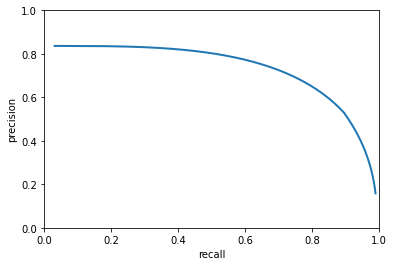

In [6]:
training_precision, training_recall = gen_pr([train_embeddings, trainY],[train_embeddings, trainY])
plt.plot(training_recall, training_precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.ylim(0,1)
plt.show()

#### Testing precision-recall curve

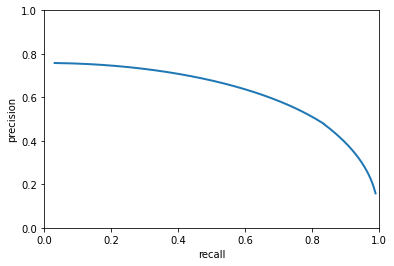

In [7]:
testing_precision, testing_recall = gen_pr([pred_train,trainY],[pred_test,testY])
plt.plot(testing_recall, testing_precision)
plt.xlabel('recall')
plt.ylabel('precision')
# plt.ylim(0,1)
plt.show()